# E17. 프로젝트 - Movielens 영화 Session Based Recommendation

이번에도 우리는 **Movielens 1M Dataset**을 기반으로, **Session based Recommendation 시스템을 제작**해 보겠습니다.

* 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 **SessionID 대신 UserID 항목이 들어갔다**는 점입니다. 
  - 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 
  - 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.


* **Rating 정보가 포함**되어 있습니다. 
  - 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 
  - 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 
  - 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.


* Time 항목에는 **UTC time 가 포함**되어, 
  - 1970년 1월 1일부터 경과된 **초단위 시간이 기재**되어 있습니다.


위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## 루브릭

|평가문항|	상세기준|
|:-------|:-------|
|1. Movielens 데이터셋을 **session based recommendation 관점으로 전처리**하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 **세션단위 정의 과정(길이분석, 시간분석)** 을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|**적절한 epoch**만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 **Recall, MRR이 개선**되는 것이 확인된다.|
|3. **세션정의, 모델구조, 하이퍼파라미터** 등을 변경해서 실험하여 **Recall, MRR 등의 변화추이를 관찰**하였다.|**3가지 이상의 변화를 시도**하고 그 실험결과를 체계적으로 분석하였다.|

* **순위 없는 평가 지표**
  - **정확도 기반 메트릭**
    - MAE, RMSE
    
  - **의사결정 지원 기반 메트릭**
    - **Confusion matrix:**  <img align='center' width='50%' src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcsmX3b%2FbtquhjiOyKI%2FoKNhWcBu2S7GY9JdLnyq4k%2Fimg.png' />
    - **정밀도(Precision) :** 모든 검출 결과물 중에서 옳게 검출한 비율
      - **정밀도(Precision):** $$Precision = \frac{TP}{TP+FP} = \frac{TP}{All~ Detections}$$
      
    - **재현율(Recall) :** 마땅히 검출해내야하는 결과물 중에서 제대로 검출한 것의 비율(검출율)
      - **재현율(Recall):**  $$Recall = \frac{TP}{TP+FN}=\frac{TP}{All~ Ground~ truths}$$
      
      
    - F1점수



* **순위 인식 평가 지표**
  - **이진 관련성(Binary relevance) 기반 메트릭**
    - 항목이 바이너리 의미에서 좋은지 여부를 파악
    - 아이템이 좋은 추천인지 그렇지 않은지에만 관심이 있다
    - Recall@K
    - MRR(평균 상호 순위)
    - MAP(평균 정밀도)
    
  - **유틸리티(Utility) 기반 메트닉**
    - 절대적 또는 상대적인 선함의 측정으로 선 / 나쁜 감각을 확장
    - 실제 랭킹의 위치, 즉 추천된 아이템이 얼마나 좋은지 혹은 어떠한 랭킹보다 더 좋은지 나쁜지에 더 중점을 둔다


* **MRR(Mean Reciprocal Rank) :** 
    - 사용자가 선호하는 아이템이 리스트 중 어디에 위치해 있는지에 중점을 둔 평가 기법
    - "주어지는 쿼리에 대해서 그 쿼리와 정확히 일치하는게 몇번째에 있는가?"를 측정
    - 추천된 리스트가 있고 사용자가 선호하는 아이템이 $k_u$라면, reciprocal rank는 $\frac{1}{k_u}$이다.
    - 모든 쿼리들에 대해서 일치하는 순서의 역순의 평균을 낸 것

    - 이진 관련성 메트릭 계열과 밀접하게 연결
    - **MRR(Mean Reciprocal Rank) :** $$MRR=\frac{1}{\left | Q \right |} \sum_{i=1}^{\left | Q \right |} \frac{1}{rank_i} $$
    - **Reciprocal Rank :**
    Query|	Proposed Results|	Correct response|	Rank|	Reciprocal rank
    :----|:-----|:-----:|:-----:|:-----:
cat|	catten, cati, cats|	cats|	3|	1/3
tori|	torii, tori, toruses|	tori|	2|	1/2
virus|	viruses, virii, viri|	viruses|	1|	1



* **MAP(Average Precision and Mean Average Precision) :**
  - 기본적인 Precision의 경우 모든 에러를 똑같은 에러로 본다.
    - 첫번째 아이템이 틀린 것과 10번째 아이템이 틀린 것을 같은 에러율로 평가한다
  - Average Precision은 상위의 아이템이 틀렸을 경우 더 높은 점수가 깎이게 되고
    - 하위의 아이템이 틀렸을 경우 더 낮은 점수가 깎이게 된다.
  - 특정 컷오프 N까지 권장 항목의 전체 목록을 평가
  - P @ N 의사 결정 지원 메트릭은 n 개의 권장 사항 중 좋은 비율을 계산

## Step 0. 데이터 읽어오기

**Movielens 1M Dataset** 읽어오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    # UserID::MovieID::Rating::Timestamp
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'MovieId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* `data_path / 'ratings.dat'` == `data_path + '/ratings.dat'`
* `pd.read_csv()`
* `.columns`
* `.sort_values()`

In [3]:
# # 시간 타입 변경
# data['Time'] = data['Time'].map(lambda x : dt.datetime.fromtimestamp(x))
# data

* `dt.datetime.fromtimestamp()`

## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 
- 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 
  - 이를 Session 단위로 어떻게 해석할지에 주의합니다.

### Step 1-1. 항목별 기본분석

[참고1](https://hogni.tistory.com/5)  
[참고2](https://dbrang.tistory.com/994)

In [4]:
# 데이터의 상위 5개의 행 출력
data.head()

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


* `.tail()`의 경우 하위 5개의 행 출력 
* 괄호 () 안에 원하는 숫자를 넣으면 그 숫자만큼 행 출력

In [5]:
# 데이터의 (행, 열) 크기 확인
data.shape

(1000209, 4)

In [6]:
# 개별 컬럼 내에 유일한 값 확인
data['UserId'].nunique(), data['MovieId'].nunique(), data['Rating'].nunique()

(6040, 3706, 5)

* 유저의 숫자가 6,040개   
* 아이템의 갯수는 3,706개   
* 등급의 갯수는 5개

* [ml-1m-README.txt](http://files.grouplens.org/datasets/movielens/ml-1m-README.txt)
  - 이 파일에는 약 3,900 편의 영화에 대한 **1,000,209 개의 익명 등급**이 포함되어 있습니다. 
  - 2000 년에 MovieLens에 가입 한 **6,040 명의 MovieLens 사용자**가 만들었습니다.

In [7]:
# 데이터에 대한 전반적인 정보
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   UserId   1000209 non-null  int32
 1   MovieId  1000209 non-null  int32
 2   Rating   1000209 non-null  int32
 3   Time     1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [8]:
# 각 칼럼마다 결측치가 몇개 있는지 확인
data.isnull().sum()   # True는 1에 대응하고, False는 0에 대응

UserId     0
MovieId    0
Rating     0
Time       0
dtype: int64

* 결측값 확인  [참고](https://workingwithpython.com/howtohandlemissingvaluewithpython/)
  - `.isnull().sum()`
  - `.notnull().sum()`
  - `.notna().sum()`

In [9]:
# 요약 통계량
data.describe()

,UserId,MovieId,Rating,Time
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [10]:
# 데이터 수집 기간 
day_sec = 24*60*60
round((data["Time"].max() - data["Time"].min())/day_sec, 1)

1038.8

In [11]:
# 등급별 데이터 갯수
data['Rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

In [12]:
# 등급별 데이터 비율
data['Rating'].value_counts(normalize=True)

4    0.348898
3    0.261142
5    0.226263
2    0.107535
1    0.056162
Name: Rating, dtype: float64

약 35%가 4등급, 26%가 3등급, 23%가 5등급 차지함

### Step 1-2. Session Length

* 같은 SessionId를 공유하는 데이터 row의 개수
* 해당 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 등급을 작성했는지)의 의미가 됩니다.

In [13]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [14]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [15]:
session_length.min(), session_length.max()

(20, 2314)

In [16]:
session_length.quantile(0.999)

1343.181000000005

각 세션의 길이는 보통 96 정도입니다.  
약 2.8년 동안 영화등급을 작성하는 것을 생각해보면 이 수치가 그럴듯하게 느껴집니다.  
99.9% 세션은 길이가 1,343 이하입니다.  
길이가 2,314인 세션은 뭔가 이상합니다.

In [17]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,MovieId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [18]:
data[data['UserId']==long_session].nunique()

UserId        1
MovieId    2314
Rating        5
Time        684
dtype: int64

* 유저 1명이 매우 짧은 간격으로 지속적으로 등급 작성을 하고 있습니다.

In [19]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합 계산
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

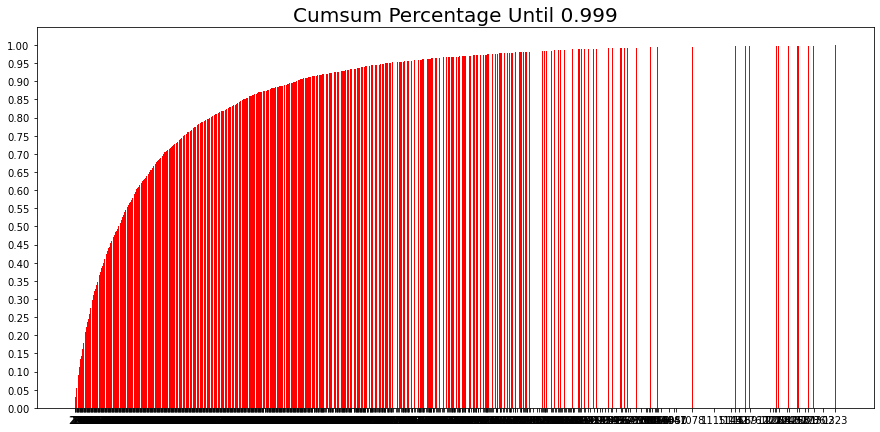

In [20]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Step 1-3. Session Time

데이터가 발생한 시간에 대해 알아보기

In [21]:
# 데이터의 시간 관련 정보를 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print('oldest :', oldest) 
print('latest :', latest)
print(f'수집 기간 [월] : {round((latest - oldest)/(30*day_sec), 1)}')

oldest : 956703932
latest : 1046454590
수집 기간 [월] : 34.6


약 35개월의 데이터가 있습니다.  
저는 최신 영화 트렌트를 학습하기 위해서 3개월 데이터만 사용하려고 합니다.

In [22]:
month_ago = latest - 3*30*day_sec             # 최종 날짜로부터 3개월 이전 날짜를 구한다.  
data_ago = data[data['Time'] > month_ago]     # 방금 구한 날짜 이후의 데이터만 모은다. 
print(month_ago)
data_ago

1038678590


,UserId,MovieId,Rating,Time
5200,36,2269,5,1040544350
5256,36,1701,4,1040544350
5184,36,2694,3,1040544494
5364,36,3786,4,1040544521
5262,36,2369,4,1040544564
...,...,...,...,...
984731,5950,3948,4,1046369637
984682,5950,3578,4,1046369670
984475,5950,3793,3,1046369710
984660,5950,3555,2,1046369737


In [23]:
week_ago1 = data_ago["Time"].max() - 1*7*day_sec
week_ago2 = data_ago["Time"].max() - 2*7*day_sec

train = data_ago[data_ago["Time"] < week_ago2 ]
valid = data_ago[(data_ago["Time"] >= week_ago2) & (data_ago["Time"] < week_ago1) ]
test = data_ago[data_ago["Time"] >= week_ago1 ]

In [24]:
train.shape, valid.shape, test.shape

((4019, 4), (216, 4), (381, 4))

In [25]:
# analysis set
print(data_ago["Time"].min(), data_ago["Time"].max())
print(round((data_ago["Time"].max() - data_ago["Time"].min())/day_sec, 1))

1038687892 1046454590
89.9


In [26]:
# train data
print(train["Time"].min(), train["Time"].max())
print(round((train["Time"].max() - train["Time"].min())/day_sec, 1))

1038687892 1045240517
75.8


In [27]:
# valid data
print(valid["Time"].min(), valid["Time"].max())
print(round((valid["Time"].max() - valid["Time"].min())/day_sec, 1))

1045268109 1045847323
6.7


In [28]:
# test data
print(test["Time"].min(), test["Time"].max())
print(round((test["Time"].max() - test["Time"].min())/day_sec, 1))

1045856844 1046454590
6.9


### Step 1-3. Data Cleansing

너무 적게 등급이 작성된 아이템은 이상한 아이템일 가능성이 있습니다.   
그러므로 길이가 1인 세션은 제거해줍니다.

In [29]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('MovieId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['MovieId'].isin(item_use)]
    return data

In [30]:
data_cleansed = cleanse_recursive(data_ago, shortest=2, least_click=5)

data_cleansed.shape

(1606, 4)

* 4616 개의 데이터에서 1604 개의 데이터만 남았다. 
* 3012(4616-1604) 개의 데이터는 short_session을 제거하고 unpopular item을 제거하면서 삭제되었다.

## Step 2. 미니 배치의 구성

* 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. 
  - Session-Parallel Mini-Batch의 개념에 따라, 
  - 학습 속도의 저하가 최소화될 수 있도록 구성합니다.


* 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 
  - Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.



### Train / Valid / Test split

Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.

이번 자료에서는 가장 마지막 1주일 기간 동안을 Test로, 2주일전부터 1주일전 까지를 valid set으로 나누겠습니다.

In [31]:
week_ago1 = data_ago["Time"].max() - 1*7*day_sec
week_ago2 = data_ago["Time"].max() - 2*7*day_sec

tr = data_cleansed[data_cleansed["Time"] < week_ago2 ]
val = data_cleansed[(data_cleansed["Time"] >= week_ago2) & (data_cleansed["Time"] < week_ago1) ]
test = data_cleansed[data_cleansed["Time"] >= week_ago1 ]

In [32]:
tr.shape, val.shape, test.shape

((1410, 4), (86, 4), (110, 4))

In [33]:
tr.sort_values(["UserId", "Time"], inplace=True)
val.sort_values(["UserId",  "Time"], inplace=True)
test.sort_values(["UserId", "Time"], inplace=True)

In [34]:
# session_last_time = data_cleansed.groupby('UserId')['Time'].max()
# session_last_time

In [35]:
# final_time = data_cleansed['Time'].max()
# session_last_time = data_cleansed.groupby('UserId')['Time'].max()
# session_in_train = session_last_time[session_last_time < final_time - 7*day_sec].index
# session_in_test = session_last_time[session_last_time >= final_time - 7*day_sec].index

In [36]:
# session_in_test

In [37]:
# before_date = data_cleansed[data_cleansed['UserId'].isin(session_in_train)]
# after_date = data_cleansed[data_cleansed['UserId'].isin(session_in_test)]
# after_date = after_date[after_date['MovieId'].isin(before_date['MovieId'])]
# train1, test1 = before_date, after_date

In [38]:
# train1.shape, test1.shape

In [39]:
# round((train1["Time"].max() - train1["Time"].min())/day_sec, 1)

In [40]:
# round((test1["Time"].max() - test1["Time"].min())/day_sec, 1)

In [41]:
# def split_by_date(data: pd.DataFrame, n_days: int):
#     final_time = data['Time'].max()
#     session_last_time = data.groupby('UserId')['Time'].max()
#     session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
#     session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

#     before_date = data[data['UserId'].isin(session_in_train)]
#     after_date = data[data['UserId'].isin(session_in_test)]
#     after_date = after_date[after_date['MovieId'].isin(before_date['MovieId'])]
#     return before_date, after_date

* `.isin()`
* `.index`

In [42]:
# # train/test 분리
# train, test = split_by_date(data_cleansed, n_days=7)

# print(train["Time"].max() - train["Time"].min())
# print(test["Time"].max() - test["Time"].min())

# # train/valid 분리
# train, valid = split_by_date(train, n_days=7)
# print(train["Time"].max() - train["Time"].min())
# print(valid["Time"].max() - valid["Time"].min())

In [43]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t UserId: {data["UserId"].nunique()}\n'
          f'\t Items: {data["MovieId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n'
          f'\t Days : {round((data["Time"].max() - data["Time"].min())/day_sec, 1)}\n')

In [44]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 1410
	 UserId: 136
	 Items: 231
	 First Time : 1038716220
	 Last Time : 1045240517
	 Days : 75.5

* valid Set Stats Info
	 Events: 86
	 UserId: 18
	 Items: 74
	 First Time : 1045268202
	 Last Time : 1045841716
	 Days : 6.6

* test Set Stats Info
	 Events: 110
	 UserId: 19
	 Items: 86
	 First Time : 1045856844
	 Last Time : 1046454320
	 Days : 6.9



In [45]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['MovieId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['MovieId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [46]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

* `.to_pickle()`

## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

### Data Pipeline  (Session-Parallel Mini-Batch 로 구현)

#### SessionDataset

In [47]:
# 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [48]:
# train데이터로 SessionDataset 객체를 만들기
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,MovieId,Rating,Time,item_idx
5364,36,3786,4,1040544521,3
5280,36,3174,4,1040544685,6
5222,36,296,5,1040545019,7
5062,36,1266,5,1040545109,9
5076,36,595,4,1040545109,10
5180,36,3639,4,1040545125,12
8704,59,2997,4,1041962568,13
8797,59,3408,4,1041962692,15
8808,59,2712,3,1041962692,16
8798,59,2396,4,1041962835,20


In [49]:
# 각 세션이 시작된 인덱스
tr_dataset.click_offsets

array([   0,    6,   41,   92,   99,  127,  133,  174,  176,  178,  181,
        184,  191,  203,  205,  298,  302,  341,  350,  359,  363,  369,
        371,  374,  379,  381,  385,  387,  395,  405,  407,  411,  413,
        422,  424,  431,  435,  443,  447,  465,  468,  487,  490,  492,
        495,  497,  501,  503,  508,  518,  520,  522,  526,  538,  547,
        550,  566,  568,  575,  594,  598,  600,  631,  639,  645,  646,
        648,  661,  677,  685,  699,  701,  707,  710,  718,  720,  722,
        728,  730,  739,  741,  795,  796,  799,  814,  819,  823,  825,
        831,  835,  845,  855,  862,  868,  883,  885,  892,  896,  901,
        905,  908,  910,  913,  916,  974,  978,  981,  988,  994,  999,
       1011, 1017, 1028, 1058, 1061, 1065, 1070, 1096, 1101, 1104, 1202,
       1219, 1234, 1248, 1253, 1257, 1262, 1278, 1282, 1287, 1290, 1292,
       1318, 1339, 1341, 1408, 1410], dtype=int32)

In [50]:
# 각 세션을 인덱싱한 np.array
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135])

####  SessionDataLoader

In [51]:
# SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [52]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,MovieId,Rating,Time,item_idx
5364,36,3786,4,1040544521,3
5280,36,3174,4,1040544685,6
5222,36,296,5,1040545019,7
5062,36,1266,5,1040545109,9
5076,36,595,4,1040545109,10
5180,36,3639,4,1040545125,12
8704,59,2997,4,1041962568,13
8797,59,3408,4,1041962692,15
8808,59,2712,3,1041962692,16
8798,59,2396,4,1041962835,20


In [53]:
iter_ex = iter(tr_data_loader)

In [54]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  3  13 132 171]
Label Item Idx are :       [  6  15 134 180]
Previous Masked Input Idx are []


### Modeling

#### Evaluation Metric

In [55]:
# MRR@k 지표
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


# recall@k 지표
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [57]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

## Step 4. 모델 학습

* 다양한 **하이퍼파라미터를 변경**해 보며 검증해 보도록 합니다. 
  - 실습코드에 언급되었던 **Recall, MRR** 등의 개념들도 함께 관리될 수 있도록 합니다.

### 하이퍼파라미터 변경

In [58]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['MovieId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=1, k=20)

In [59]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 231)]          0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  42450     
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 231)               11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [60]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [61]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train: 0it [00:00, ?it/s]


IndexError: index 136 is out of bounds for axis 0 with size 136

## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 **Recall, MRR** 을 확인해 봅니다.
  

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

## 회고
* 추천 시스템의 평가지표를 이해하는데 어려웠다.
* train / valid / test 데이터를 분리하는 함수의 사용에 많은 어려움이 있었다.
  - 함수를 사용한 경우에 train / valid / test 기간이 겹쳐서 문제가 발생함
  - 함수를 사용하지 않고 직접 분할함
  - 학습을 진행하는데 에러 발생함
    - tqdm() 함수의 기능이 진행상황을 알기 위해서 사용하는 것으로만 알고 있었는데
      - 여기에서는 반복문에 사용하는 인수로도 사용하는데 좀더 공부하여 알아야겠다.

# End